# Assignment 2

In [ ]:
# =================================================================================================
# Authors: Andrei Landayan Angeles (), Chathu Siriwardena (), Mark Sturtz (218306846)
# Description: Code document for group assessment task 2.
# =================================================================================================
# Version     |    Date      |    Author        |  Updates
# 0.1         |  23-Aug-2024 |    Andrei        |  Initial Version - Creating Git Repo
# 0.2         |  25-Aug-2024 |    Mark          |  Minor changes to log, add library imports & load data in spark df
# 0.3         |  30-Aug-2024 |    Mark          |  Directly read data using spark
# 0.4         |  31-Aug-2024 |    Chathu        |  Answer 1.6
# 0.5         |  31-Aug-2024 |    Chathu        |  Answer 1.7
# 0.6         |  10-Sep-2024 |    Andrei        |  Answer 1.8, Editted 1.1, 1.4, changed some of the Libary
# 0.7         |  15-Sep-2024 |    Chathu        |  Answer 1.9
# 0.8         |  19-Sep-2024 |    Mark          |  Answer 1.10 (1.10.1, 1.10.2, 1.10.3)
# 0.9         |  19-Sep-2024 |    Mark          |  Answer 2.1
# 0.9         |  19-Sep-2024 |    Mark          |  refactor code for Q1.8, standardise pyspark.sql.functions by using F, removed redundant imports, tidy code

#### Library Imports

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import ArrayType, StringType
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics.pairwise import euclidean_distances
from mlxtend.frequent_patterns import apriori, association_rules

warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
# Initialize Spark session
spark = SparkSession.builder.appName("SIT742Task2").getOrCreate()

#### Load Data

In [4]:
# define external path with getcwd()
external_path = os.getcwd()

# define path do data
data_path = external_path+'/data/transactionrecord'

# create spark df
df = spark.read.format("csv").options(header='true', inferSchema='true', delimiter=',').load(data_path)

# display the first 5 rows
df.show(n=5)

+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|
|       581475|12/9/2019|    22596|Christmas Star Wi...|             0ca|10.65|      36|     13069|United Kingdom|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|             0ca|11.53|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|             0ca|10.65|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23239|Set Of 4 Knick Kn...|             0ca|11.94|       6|     13069|United Kingdom|
+-------------+---------+---------+--------------------+----------------+-----+-

## Part 1

##### Answer 1.1

In [5]:
# 1.1.1 - Replace 'NA' in the CustomerNo column with '-1'
df = df.withColumn("CustomerNo", F.when(F.col("CustomerNo") == "NA", "-1").otherwise(F.col("CustomerNo")))

# 1.1.2 - Remove digits and ensure only one space between words
df = df.withColumn("productName_process", F.concat_ws(" ", F.split(F.trim(F.translate(F.col("ProductName"), "0123456789", "")), "\\s+")))

# Displays the first five rows of the transactionrecord
df.show(5)

+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+--------------------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country| productName_process|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+--------------------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|Set Of Wooden Mar...|
|       581475|12/9/2019|    22596|Christmas Star Wi...|             0ca|10.65|      36|     13069|United Kingdom|Christmas Star Wi...|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|             0ca|11.53|      12|     13069|United Kingdom|Storage Tin Vinta...|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|             0ca|10.65|      12|     13069|United Kingdom|Tree T-Light Hold...|
|       581475|12/9/2019|    23239|Set Of 4 Knic

##### Answer 1.2

+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+--------------------+-------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country| productName_process|Revenue|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+--------------------+-------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|Set Of Wooden Mar...| 257.64|
|       581475|12/9/2019|    22596|Christmas Star Wi...|             0ca|10.65|      36|     13069|United Kingdom|Christmas Star Wi...|  383.4|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|             0ca|11.53|      12|     13069|United Kingdom|Storage Tin Vinta...| 138.36|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|             0ca|10.65|      12|     13069|United Kingdom|Tree T-Light Hold...| 

  TransactionNo       Date ProductNo                          ProductName  \
0        581482  12/9/2019     22485        Set Of 2 Wooden Market Crates   
1        581475  12/9/2019     22596  Christmas Star Wish List Chalkboard   
2        581475  12/9/2019     23235             Storage Tin Vintage Leaf   
3        581475  12/9/2019     23272    Tree T-Light Holder Willie Winkie   
4        581475  12/9/2019     23239    Set Of 4 Knick Knack Tins Poppies   

  Product_category  Price  Quantity CustomerNo         Country  \
0              0ca  21.47        12      17490  United Kingdom   
1              0ca  10.65        36      13069  United Kingdom   
2              0ca  11.53        12      13069  United Kingdom   
3              0ca  10.65        12      13069  United Kingdom   
4              0ca  11.94         6      13069  United Kingdom   

                   productName_process     Revenue transaction_date  
0          Set Of Wooden Market Crates  257.640015       2019-12-09  


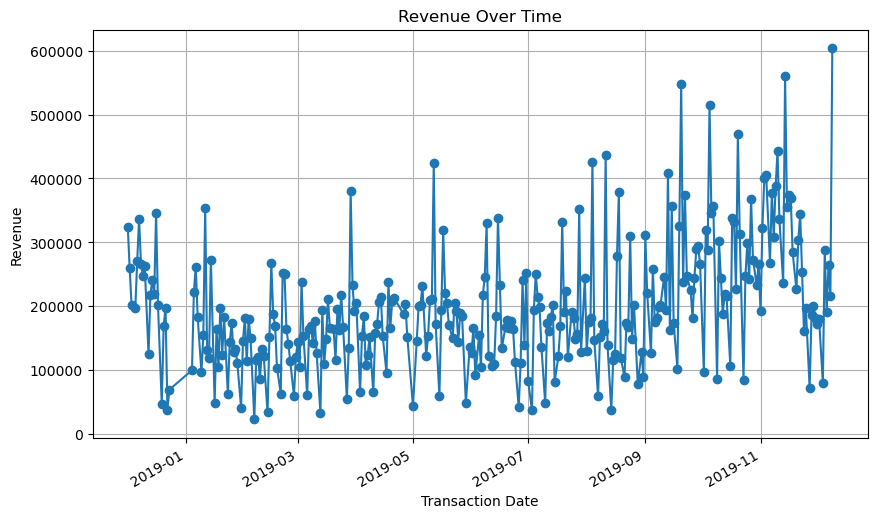

In [6]:
#1.2.1
# Calculates the revenue and displays the first 5 rows.
df = df.withColumn("Revenue", (F.col("Price") * F.col("Quantity")).cast("float"))
df.show(5)

#1.2.2
# Converts to pandas, and creates a transaction_date, and shows first 5 rows.
df_pandas = df.toPandas()
df_pandas['transaction_date'] = pd.to_datetime(df_pandas['Date'], format="%m/%d/%Y")
print(df_pandas.head(5))

#1.2.3
# Plots the revenue over time
df_grouped = df_pandas.groupby('transaction_date')['Revenue'].sum()
df_grouped.plot(title='Revenue Over Time', xlabel='Transaction Date', ylabel='Revenue', figsize=(10, 6), marker='o')
plt.grid(True)
plt.show()

##### Answer 1.3

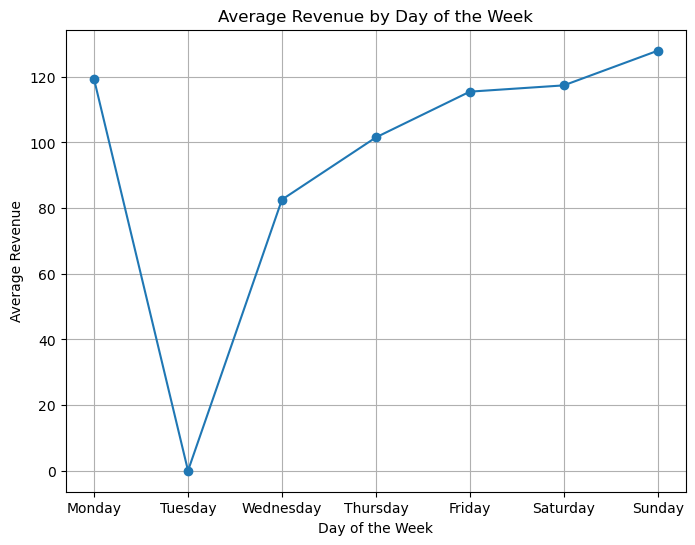

The workday with the highest average revenue is: Sunday


In [7]:
# 1.3.1
#Extract the day of the week from transaction_date
df_pandas['day_of_week'] = df_pandas['transaction_date'].dt.day_name()

# Average revenue by day of the week
average_revenue_by_day = df_pandas.groupby('day_of_week')['Revenue'].mean()

# Plot of average revenue by day of the week
average_revenue_by_day = average_revenue_by_day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).replace(np.nan, 0)
average_revenue_by_day.plot(title='Average Revenue by Day of the Week', xlabel='Day of the Week', ylabel='Average Revenue', figsize=(8, 6), marker='o')
plt.grid(True)
plt.show()

# Workday with the highest average revenue
highest_revenue_day = average_revenue_by_day.idxmax()
print(f"The workday with the highest average revenue is: {highest_revenue_day}")

In [8]:
# 1.3.2 Filter the DataFrame for the top workday
df_top_workday = df_pandas[df_pandas['day_of_week'] == highest_revenue_day]

# The product with the highest revenue on that workday
top_product_by_revenue = df_top_workday.groupby('productName_process')['Revenue'].sum().idxmax()
print(f"The product with the highest revenue on {highest_revenue_day} is: {top_product_by_revenue}")

# The product with the highest sales volume on that workday
top_product_by_volume = df_top_workday.groupby('productName_process')['Quantity'].sum().idxmax()
print(f"The product with the highest sales volume on {highest_revenue_day} is: {top_product_by_volume}")

The product with the highest revenue on Sunday is: World War Gliders Asstd Designs
The product with the highest sales volume on Sunday is: World War Gliders Asstd Designs


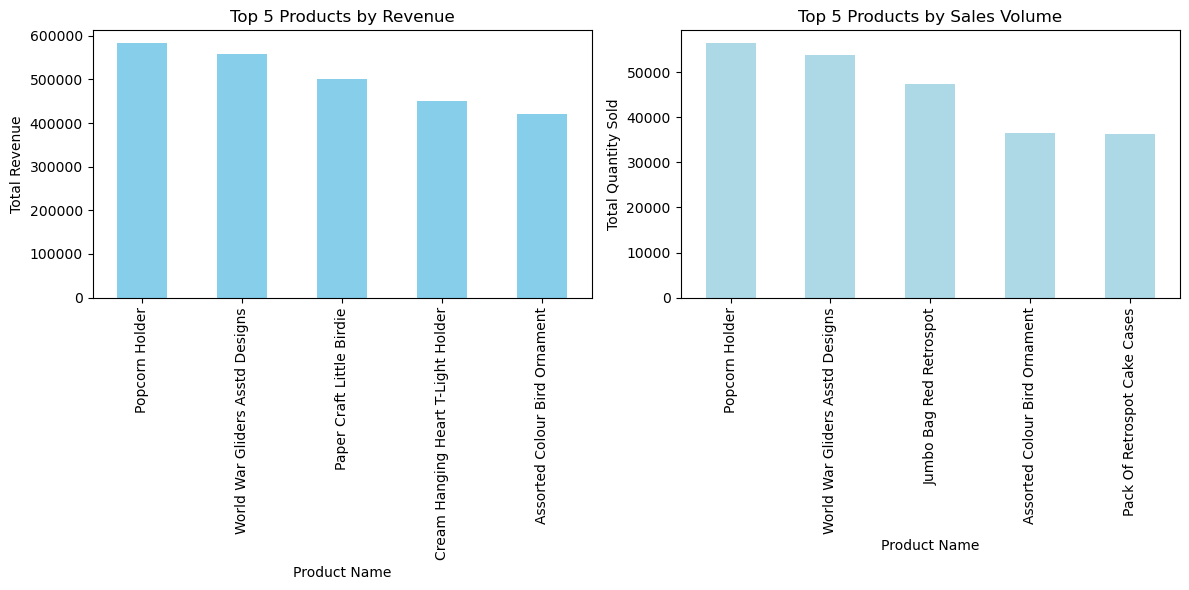

In [9]:
# 1.3.3 Find the top 5 products by revenue in general
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Top 5 products by revenue in general
top_5_products_by_revenue = df_pandas.groupby('productName_process')['Revenue'].sum().nlargest(5)

# Plot the top 5 products by revenue
top_5_products_by_revenue.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Top 5 Products by Revenue')
axes[0].set_xlabel('Product Name')
axes[0].set_ylabel('Total Revenue')

# Top 5 products by sales volume in general
top_5_products_by_volume = df_pandas.groupby('productName_process')['Quantity'].sum().nlargest(5)

# Plot the top 5 products by sales volume
top_5_products_by_volume.plot(kind='bar', ax=axes[1], color='lightblue')
axes[1].set_title('Top 5 Products by Sales Volume')
axes[1].set_xlabel('Product Name')
axes[1].set_ylabel('Total Quantity Sold')

plt.tight_layout()

# Display the plots
plt.show()

##### Answer 1.4

In [10]:
# Use to_timestamp to handle inconsistent formats and ensure proper date conversion
df = df.withColumn("Date", F.to_date(F.to_date(F.col("Date"), "M/d/yyyy"), "MM/dd/yyyy"))

# 1.4.1 - Calculate total revenue per country
country_rev = df.groupBy("Country").agg(F.sum("Revenue").alias("TotalRevenue"))

# 1.4.2 - Show the country with the highest revenue
best_country = country_rev.orderBy(F.col("TotalRevenue").desc()).first()["Country"]
print(f"The country with the highest revenue is: {best_country}")

# 1.4.3 - Calculate monthly revenue for the best country
monthly_rev = df.filter(F.col("Country") == best_country).groupBy(F.date_format(F.col("Date"), "MMMM").alias("Best Month")).agg(F.sum("Revenue").alias("Monthly Revenue")).orderBy(F.col("Monthly Revenue").desc())

# 1.4.4 - Show the highest revenue month
monthly_rev.show(1, truncate=False)

The country with the highest revenue is: United Kingdom


+----------+----------------+
|Best Month|Monthly Revenue |
+----------+----------------+
|November  |6737639.98568058|
+----------+----------------+
only showing top 1 row



#### Answer 1.5

In [11]:
# 1.5.1
# Filter out transc with quantity <= 0
valid_transactions = df.filter(F.col("Quantity") > 0)

# 1.5.2
# Find shopping frequency by counting the distinct transc per customer
customer_freq = valid_transactions.groupBy("CustomerNo").agg(F.countDistinct("TransactionNo").alias("ShoppingFrequency"))

# 1.5.3
# Find the customer with the highest shopping frequency
most_frequent_customer = customer_freq.orderBy(F.col("ShoppingFrequency").desc()).first()["CustomerNo"]
print(f"The customer who shops most frequently is: {most_frequent_customer}")

# 1.5.4
# Find the products based on the most freq customer and the products
customer_products = valid_transactions.filter(F.col("CustomerNo") == most_frequent_customer).groupBy("productName_process").agg(F.sum("Quantity").alias("TotalQuantity")).orderBy(F.col("TotalQuantity").desc())

# 1.5
# Show the products and quantity
customer_products.show(truncate=False)

The customer who shops most frequently is: 12748
+-----------------------------------+-------------+
|productName_process                |TotalQuantity|
+-----------------------------------+-------------+
|Victorian Metal Postcard Spring    |595          |
|World War Gliders Asstd Designs    |480          |
|Rose Scent Candle Jewelled Drawer  |408          |
|Cartoon Pencil Sharpeners          |405          |
|Small White Retrospot Mug In Box   |390          |
|Vanilla Scent Candle Jewelled Box  |380          |
|Small Red Retrospot Mug In Box     |372          |
|Bubblegum Ring Assorted            |318          |
|Popart Wooden Pencils Asst         |300          |
|Ocean Scent Candle In Jewelled Box |225          |
|Pens Assorted Funny Face           |216          |
|Assorted Creepy Crawlies           |216          |
|Garage Key Fob                     |174          |
|Marie Antoinette Trinket Box Silver|168          |
|Key Fob Shed                       |164          |
|Brocade Ring P

#### Answer 1.6

In [12]:
# 1.6.1
#Group by the transactionNo and aggregate the category of product

df_basket = valid_transactions.groupBy("TransactionNo").agg(
    F.collect_list("product_category").alias("ProductCategoryList"),
    F.collect_list("productName_process").alias("ProductNameList")
)

df_basket.show(10,truncate=False)

# 1.6.2
# Define a Function to remove duplicates
def remove_adjacent_duplicates(lst):
    if lst is None:
        return []
    return [x for i, x in enumerate(lst) if i == 0 or x != lst[i - 1]]

# Convert the function to PySpark UDF
remove_adjacent_duplicates_udf = F.udf(remove_adjacent_duplicates, ArrayType(StringType()))

# Apply the UDF
df_1 = df_basket.withColumn("productCategoryList", remove_adjacent_duplicates_udf(F.col("productCategoryList")))

#Show the df_1
df_1.show(10, truncate=False)

+-------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+-------------+-------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Answer 1.7

In [13]:
#1.7.1
# Create the 'prod_len' column
df_1 = df_1.withColumn("prod_len", F.size("productCategoryList"))

# Show the first 5 rows
df_1.select("TransactionNo", "productCategoryList", "prod_len").show(5, truncate=False)

#1.7.2
# Define a Function to transform the list into the path format
def transform_to_path(categories):
    return "start > " + " > ".join(categories) + " > conversion"

transform_to_path_udf = F.udf(transform_to_path, StringType())

# Apply the transformation
df_1 = df_1.withColumn("path", transform_to_path_udf("productCategoryList"))

# Show the first 10 rows
df_1.select("TransactionNo", "productCategoryList", "prod_len", "path").show(10, truncate=False)

def data_processing(df, maxlength=3, minlength=1):
    # Filter based on prod_len
    filtered_df = df.filter((F.col("prod_len") <= maxlength) & (F.col("prod_len") >= minlength))

    # Transform the list into the required path format
    df_2 = filtered_df.withColumn("path", transform_to_path_udf("productCategoryList"))
    return df_2

# Apply the function with maxlength=5, minlength=2
df_2 = data_processing(df_1, maxlength=5, minlength=2)

# Show the top 10 rows
df_2.select("TransactionNo", "productCategoryList", "prod_len", "path").show(10, truncate=False)


+-------------+-------------------+--------+
|TransactionNo|productCategoryList|prod_len|
+-------------+-------------------+--------+
|536366       |[0ca]              |1       |
|536367       |[0ca]              |1       |
|536371       |[0ca]              |1       |
|536374       |[0ca]              |1       |
|536375       |[0ca]              |1       |
+-------------+-------------------+--------+
only showing top 5 rows

+-------------+-------------------+--------+------------------------+
|TransactionNo|productCategoryList|prod_len|path                    |
+-------------+-------------------+--------+------------------------+
|536366       |[0ca]              |1       |start > 0ca > conversion|
|536367       |[0ca]              |1       |start > 0ca > conversion|
|536371       |[0ca]              |1       |start > 0ca > conversion|
|536374       |[0ca]              |1       |start > 0ca > conversion|
|536375       |[0ca]              |1       |start > 0ca > conversion|
|536377   

#### Answer 1.8

In [32]:
# define product categories
product_categories = ['0ca', '1ca', '2ca', '3ca', '4ca', 'conversion']

# store results fpr 1.8.1 & 1.8.2 as lists
answer_181 = []
answer_182 = []

# save product occurnaces counts as a list
product_pattern_occurances = []

# loop through each product in product_categories
for product in product_categories:

    # 1.8.1 - Count the transactions that end with the specific patterns. append to answer_181 and skip element 'conversion'
    if product != 'conversion':  
        product_conversion = df_2.filter(F.col("path").endswith(f"{product} > conversion")).count()
        answer_181.append(f"Transactions ending with '{product} > conversion': {product_conversion}")
    
    # 1.8.2 - Count the occurences with the specific patterns in transactions. . append to answer_182
    product_pattern_occurance = df_2.filter(F.col("path").contains(f"{product_categories[0]} > {product}")).count()
    product_pattern_occurances.append(product_pattern_occurance)
    answer_182.append(f"Transactions containing '{product_categories[0]} > {product}': {product_pattern_occurance}")

# print result of 1.8.1 & 1.8.2
print("Results for 1.8.1:")
[print(i) for i in answer_181]
print("\nResults for 1.8.2:")
[print(i) for i in answer_182]

# 1.8.3 - Count the transactions that contain '0ca' anywhere
print("\nResults for 1.8.3:")
count_0ca_anywhere = df_2.filter(F.col("path").contains("0ca")).count()
print(f"Transactions containing '0ca': {count_0ca_anywhere}")

# 1.8.4 - Calculate the final result (Use the 6 results from 1.8.2 to divide result from 1.8.3 then sum)
print("\nResults for 1.8.4:")

total_sum = sum([product_pattern_occurance / count_0ca_anywhere for product_pattern_occurance in product_pattern_occurances])
print("Final result for 1.8.4: %.3f" % (total_sum))

Results for 1.8.1:
Transactions ending with '0ca > conversion': 3054
Transactions ending with '1ca > conversion': 26
Transactions ending with '2ca > conversion': 144
Transactions ending with '3ca > conversion': 69
Transactions ending with '4ca > conversion': 199

Results for 1.8.2:
Transactions containing '0ca > 0ca': 0
Transactions containing '0ca > 1ca': 1195
Transactions containing '0ca > 2ca': 1130
Transactions containing '0ca > 3ca': 340
Transactions containing '0ca > 4ca': 1177
Transactions containing '0ca > conversion': 3054

Results for 1.8.3:
Transactions containing '0ca': 3492

Results for 1.8.4:
Final result for 1.8.4: 1.975


#### Answer 1.9




In [15]:
# 1.9.1- Build the transaction level product dataframe

# Filter out transactions with negative quantities
df_filtered = df_pandas[df_pandas['Quantity'] > 0]

# Identify the top 100 products by total quantity
top_products = df_filtered.groupby('productName_process')['Quantity'].sum().nlargest(100).index

# Filter the DataFrame to include only these top products
df_top_products = df_filtered[df_filtered['productName_process'].isin(top_products)]

# Pivot the DataFrame to  build the transaction level product dataframe
df_pivot = df_top_products.pivot_table(index='TransactionNo', columns='productName_process', values='Quantity', fill_value=0)

print(df_pivot.head(5))

productName_process  """Assorted Flower Colour """"Leis"""""""  \
TransactionNo                                                    
536365                                                     0.0   
536367                                                     0.0   
536370                                                     0.0   
536371                                                     0.0   
536373                                                     0.0   

productName_process  Aged Glass Silver T-Light Holder  \
TransactionNo                                           
536365                                            0.0   
536367                                            0.0   
536370                                            0.0   
536371                                            0.0   
536373                                            0.0   

productName_process  Antique Silver T-Light Glass  \
TransactionNo                                       
536365                         

In [16]:
# 1.9.1 -Apriori algorithm to identify items with a minimum support of 1.5% for baskets with 4 or more items

# Filter baskets with 4 or more items
df_pivot = df_pivot[df_pivot.apply(lambda x: (x > 0).sum(), axis=1) >= 4]

# Convert to boolean format
df_pivot_bool = df_pivot.applymap(lambda x: x > 0)

# Run Apriori algorithm
frequent_itemsets = apriori(df_pivot_bool, min_support=0.015, use_colnames=True)

# Display the frequent itemsets
print(frequent_itemsets)

/tmp/ipykernel_58499/1905987681.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pivot_bool = df_pivot.applymap(lambda x: x > 0)


       support                                           itemsets
0     0.031276                 (Aged Glass Silver T-Light Holder)
1     0.085835                     (Antique Silver T-Light Glass)
2     0.126928                    (Assorted Colour Bird Ornament)
3     0.054698                        (Assorted Colours Silk Fan)
4     0.057083                             (Bag g Swirly Marbles)
...        ...                                                ...
4367  0.015989  (Charlotte Bag Pink Polkadot, Red Retrospot Ch...
4368  0.015147  (Lunch Bag Suki Design, Lunch Bag Spaceboy Des...
4369  0.015428  (Lunch Bag Woodland, Lunch Bag Suki Design, Lu...
4370  0.015288  (Lunch Bag Woodland, Lunch Bag Suki Design, Lu...
4371  0.015147  (Lunch Bag Woodland, Lunch Bag Suki Design, Lu...

[4372 rows x 2 columns]


In [17]:
#1.9.3- Apriori algorithm to find the items with support>=1.0% and lift>10

# Calculate association rules with lift > 10
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=10)

# Display rules with support ≥ 1.0%
rules = rules[rules['support'] >= 0.01]

print(rules)

                                            antecedents  \
0                 (Wooden Heart Christmas Scandinavian)   
1                  (Wooden Star Christmas Scandinavian)   
2     (Wooden Heart Christmas Scandinavian, Paper Ch...   
3     (Wooden Star Christmas Scandinavian, Paper Cha...   
4                 (Wooden Heart Christmas Scandinavian)   
...                                                 ...   
2621  (Lunch Bag Woodland, Lunch Bag Suki Design, Lu...   
2622  (Lunch Bag Woodland, Lunch Bag Cars Blue, Lunc...   
2623  (Lunch Bag Suki Design, Lunch Bag Spaceboy Des...   
2624  (Lunch Bag Cars Blue, Lunch Bag Spaceboy Desig...   
2625  (Lunch Bag Spaceboy Design, Lunch Bag Pink Pol...   

                                            consequents  antecedent support  \
0                  (Wooden Star Christmas Scandinavian)            0.054979   
1                 (Wooden Heart Christmas Scandinavian)            0.053296   
2                  (Wooden Star Christmas Scandinavian

In [18]:
#1.9.4- Explore three more examples with different support/confidence/lift measurements

# Example 1: Support ≥ 0.02 and Confidence ≥ 0.5
rules_1 = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
rules_1 = rules_1[rules_1['support'] >= 0.02]
print(rules_1)

# Example 2: Support ≥ 0.03 and Lift ≥ 5
rules_2 = association_rules(frequent_itemsets, metric="lift", min_threshold=5)
rules_2 = rules_2[rules_2['support'] >= 0.03]
print(rules_2)

# Example 3: Support ≥ 0.01 and Confidence ≥ 0.7
rules_3 = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
rules_3 = rules_3[rules_3['support'] >= 0.01]
print(rules_3)

#Save your code and results in a clean and tidy format and writing down your insights

# Save frequent itemsets
frequent_itemsets.to_csv('frequent_itemsets.csv', index=False)

# Save association rules
rules.to_csv('/association_rules.csv', index=False)
rules_1.to_csv('/association_rules_example_1.csv', index=False)
rules_2.to_csv('/association_rules_example_2.csv', index=False)
rules_3.to_csv('/association_rules_example_3.csv', index=False)

                                            antecedents  \
0                        (Cake Cases Vintage Christmas)   
1                         (Charlotte Bag Pink Polkadot)   
2                         (Red Retrospot Charlotte Bag)   
3                         (Charlotte Bag Pink Polkadot)   
4                         (Charlotte Bag Pink Polkadot)   
...                                                 ...   
7233  (Lunch Bag Woodland, Lunch Bag Suki Design, Lu...   
7234  (Lunch Bag Woodland, Lunch Bag Suki Design, Lu...   
7235  (Lunch Bag Woodland, Lunch Bag Cars Blue, Lunc...   
7236  (Lunch Bag Woodland, Lunch Bag Cars Blue, Lunc...   
7237  (Lunch Bag Woodland, Lunch Bag Black Skull, Lu...   

                                           consequents  antecedent support  \
0                       (Paper Chain Kit 'S Christmas)            0.070687   
1                          (Charlotte Bag Suki Design)            0.098177   
2                        (Charlotte Bag Pink Polkadot)   

OSError: [Errno 30] Read-only file system: '/association_rules.csv'

#### Answer 1.10

Answer 1.10.1

In [19]:
# filter df to exclude values of quantity less than zero
df2 = df.filter(df['Quantity'] > 0)

# aggregate productName_process by sum of quantity as total_qty
product_qty_agg = df2.groupBy('productName_process').agg(F.sum('quantity').alias('total_qty'))

# subset product_qty_agg to collect the first 100 products by total_qty
subset_agg_df = product_qty_agg.orderBy('total_qty', ascending=False).limit(100).select('productName_process').rdd.flatMap(lambda x: x).collect()

# filter for the top 100 products
top_100_products_df = df2.filter(df2['productName_process'].isin(subset_agg_df))

# group by CustomerNo and pivot datafrane to have productName_process values as columns
customer_product_df = top_100_products_df.groupBy('CustomerNo').pivot('productName_process', subset_agg_df).agg(F.sum('quantity')).fillna(0)

# display the first ten records from customer_product_df
customer_product_df.show(10)

24/09/19 12:42:50 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+-------------------------+------------------------------+--------------+-------------------------------+-----------------------+----------------------------------+----------------------------+-----------------------------+------------------+----------------------+----------------------+-------------------------------+-------------------------------+-------------------------+------------------+--------------------+-----------------------+-----------------------+-----------------------+----------------------------+----------------------------+-------------+------------------------+-------------------------+---------------------+---------------------------+--------------------+-----------------------------------+----------------------+----------------------------------+----------------------------+--------------------+------------------------+-------------------------+----------------+------------------+------------------+-----------------------------+-------------------------

Answer 1.10.2

In [20]:
# convert to Pandas DataFrame
customer_product_pd_df = customer_product_df.toPandas().set_index('CustomerNo')

# store customerno index
idx = customer_product_pd_df.index

# calculate euclidian distances using scikit-learn euclidean_distances | https://scikit-learn.org/0.16/modules/generated/sklearn.metrics.pairwise.euclidean_distances.html
customer_product_distances_df = pd.DataFrame(euclidean_distances(customer_product_pd_df, customer_product_pd_df), index=idx, columns=idx)

# remove multi-index by setting name to none
customer_product_distances_df.index.name = None

# display N*N matrix distances
customer_product_distances_df

,15555,15271,14204,13282,17686,12847,14157,13610,18130,16504,...,13095,13922,12857,14805,16679,16363,16751,13354,17351,14167
15555,0.000000,198.212008,183.893991,186.180020,229.812967,201.101964,185.164791,184.374619,183.983695,187.400640,...,190.457344,184.016304,184.667268,184.314948,185.865543,184.699756,242.837394,186.252517,185.736372,184.247117
15271,198.212008,0.000000,84.350459,89.235643,163.285027,118.667603,84.640416,81.314205,108.157293,97.072138,...,96.943282,81.473922,84.439327,84.237759,87.578536,85.076436,198.982411,86.752522,87.028731,83.743656
14204,183.893991,84.350459,0.000000,29.933259,163.300337,83.755597,20.518285,13.892444,68.636725,48.620983,...,48.280431,7.937254,14.387495,5.385165,24.556058,13.076697,180.352433,26.888659,24.556058,5.291503
13282,186.180020,89.235643,29.933259,0.000000,163.600122,89.044932,36.537652,32.726136,75.239617,57.253821,...,56.964901,31.256999,33.481338,30.708305,38.948684,32.939338,182.868805,40.755368,38.948684,30.692019
17686,229.812967,163.285027,163.300337,163.600122,0.000000,183.510218,164.127999,159.518024,171.650808,166.448190,...,170.270373,162.074057,161.703432,163.370744,165.118140,163.804762,243.285840,165.553617,165.118140,163.134913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16363,184.699756,85.076436,13.076697,32.939338,163.804762,84.451169,23.194827,17.944358,69.742383,49.809638,...,49.477268,13.416408,18.000000,12.083046,26.832816,0.000000,180.676506,29.393877,26.832816,12.041595
16751,242.837394,198.982411,180.352433,182.868805,243.285840,198.715878,181.367031,180.770573,184.986486,186.646725,...,186.558302,180.377382,180.776105,180.283111,181.868084,180.676506,0.000000,182.263545,181.868084,180.280337
13354,186.252517,86.752522,26.888659,40.755368,165.553617,87.795216,31.906112,29.966648,71.777434,54.854353,...,54.990908,27.495454,30.000000,26.419690,36.000000,29.393877,182.263545,0.000000,36.000000,26.851443
17351,185.736372,87.028731,24.556058,38.948684,165.118140,86.971260,31.144823,27.459060,72.773622,53.972215,...,53.665631,24.738634,27.495454,24.041631,33.941125,26.832816,181.868084,36.000000,0.000000,24.020824


Answer 1.10.3

In [21]:
print(f'top 3 most similar customers to customer 13069: {customer_product_distances_df['13069'].sort_values().iloc[1:4].index.to_numpy()}\n')
print(f'top 3 most similar customers to customer 17490: {customer_product_distances_df['17490'].sort_values().iloc[1:4].index.to_numpy()}\n')

top 3 most similar customers to customer 13069: ['15118' '17523' '18179']

top 3 most similar customers to customer 17490: ['12582' '12519' '12652']



Answer 1.10.4

<Axes: >

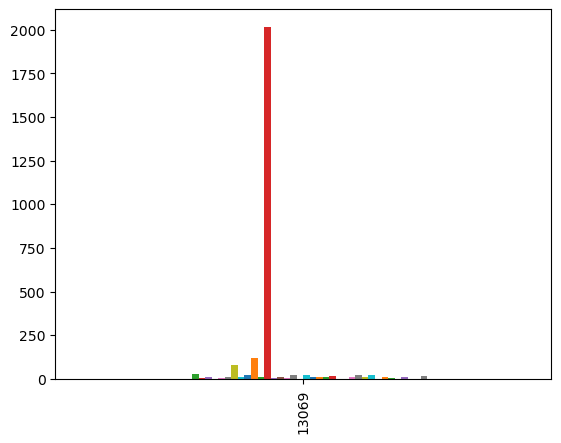

In [22]:
# review customer 13069 purchases 
customer_13069 = customer_product_pd_df.loc['13069'].to_frame().T

# dataframe of purchased items for customer 13069
cust_13069_purchased_items = customer_13069[customer_13069.apply(lambda x: x > 0)].dropna(axis=1)

# dataframe of non-purchased items for customer 13069
cust_13069_non_purchased_items = customer_13069[~customer_13069.apply(lambda x: x > 0)].dropna(axis=1)

cust_13069_purchased_items.plot(kind='bar',legend=False)


## Part 2

##### Answer 2.1

In [23]:
# aggregate revenue transaction by date and cast to pandas dataframe
date_revenue_df = (
    df.select(F.col('Date'), F.col('Revenue')) \
       .orderBy('Date') \
       .groupby('Date').sum() \
       .toPandas()
).rename(columns={'sum(Revenue)':'Revenue'})

# collect the mean revenue from the dataset
mean_revenue = date_revenue_df['Revenue'].mean()

print(f'length of date revenue dataset before adding missing date records: {len(date_revenue_df)}')

# convert Date column from objetc to datetime format
date_revenue_df['Date'] = pd.to_datetime(date_revenue_df['Date'],format='%Y/%d,%m')

# create dateIndex between 2018-12-01 & 2019-12-09. also cast to pd.Series
complete_dates_s = pd.date_range(start='2018-12-01', end='2019-12-09', freq='D').to_series().rename('Date')

# complete a left join to merge on complete_dates_s, date_revenue_df, fill NaN values with the mean_revenue & set date as index
date_revenue_processed_df = pd.merge(complete_dates_s, date_revenue_df, how='left').fillna(mean_revenue).set_index('Date').rename_axis(None)

print(f'length of date revenue dataset after adding missing date records: {len(date_revenue_processed_df)}')

length of date revenue dataset before adding missing date records: 305
length of date revenue dataset after adding missing date records: 374


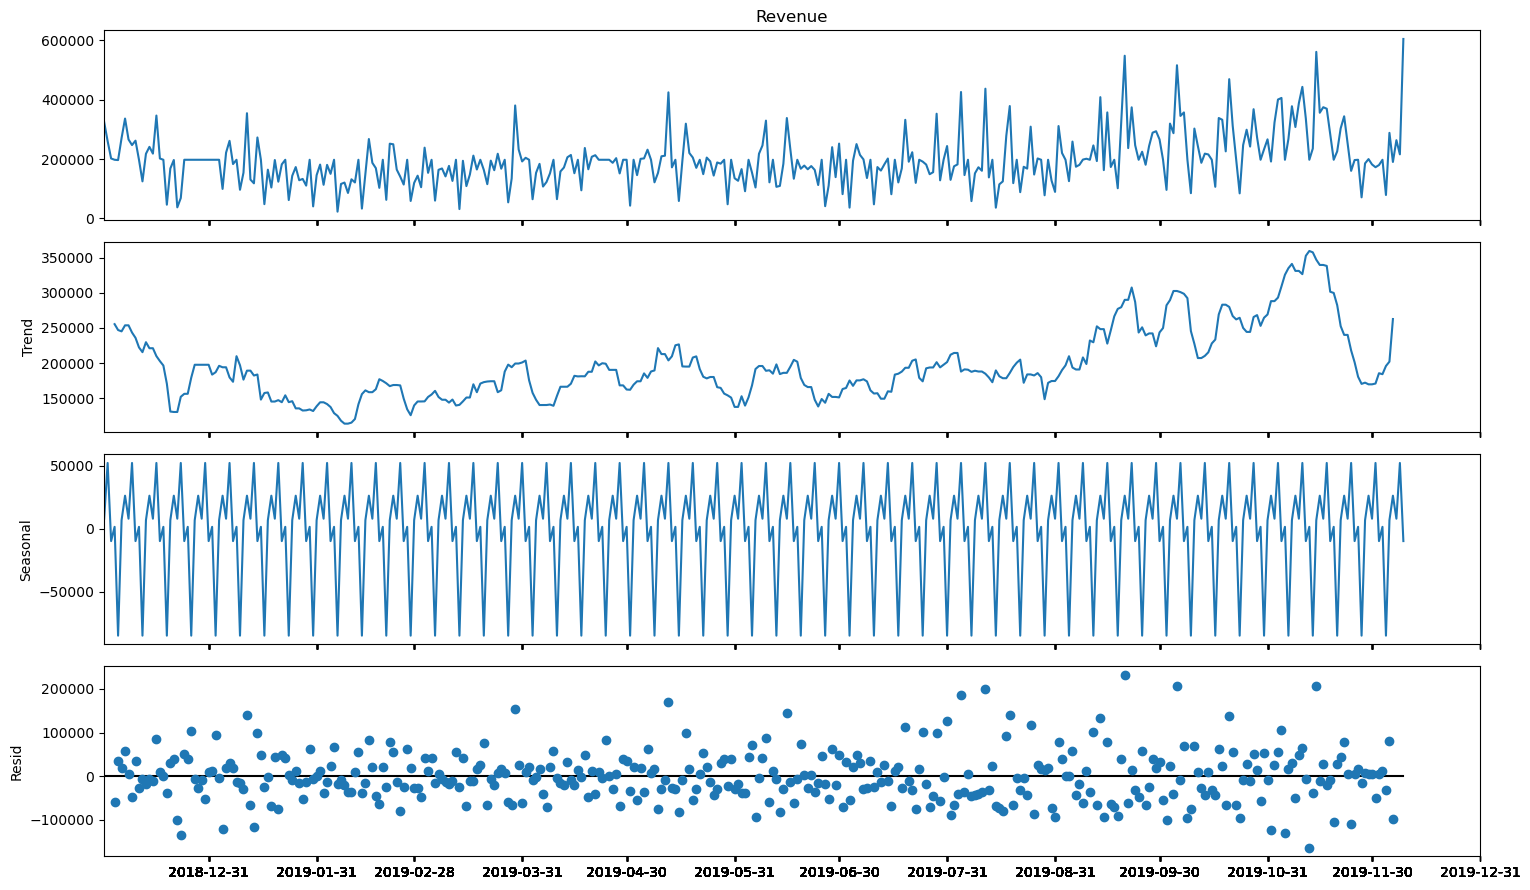

In [24]:
# additive model for seasonal decomposition
add_result = seasonal_decompose(date_revenue_processed_df['Revenue'], model='additive')

# plot model results
plt.rcParams["figure.figsize"] = (15,9)
add_result.plot()

# set x axis frequency to monthly
plt.xticks(complete_dates_s.dt.to_period('M'))
plt.show()